### Here I am creating a CNN for Pneumonia disease classification on chest X-Ray images

In [1]:
# Import all the necessary libraries

import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import pandas as pd
import numpy as np

### Loding and Preprocessing Step

1. Create Datagenerator instances for train, test and validation
2. Apply data augmentation to traning images for better training of the model

In [2]:
train_idg = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 30,  
    zoom_range = 0.2, 
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip = True,
)
test_idg = ImageDataGenerator(
    rescale = 1./255.
)
val_idg = ImageDataGenerator(
    rescale=1./255.
)

In [3]:
IMG_SIZE = (224, 224)

train = train_idg.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/train', 
                                      class_mode='binary',
                                      color_mode="grayscale",
                                      target_size = IMG_SIZE
                                     )
test = test_idg.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/test', 
                                    class_mode='binary',
                                    color_mode="grayscale",
                                    target_size = IMG_SIZE
                                   )
val = val_idg.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/val',
                                  class_mode='binary',
                                  color_mode="grayscale",
                                  target_size = IMG_SIZE
                                 )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [4]:
trainX, trainY = train.next()
testX, testY = test.next()
valX, valY = val.next()

In [5]:
print(len(trainX), len(trainY))

32 32


In [6]:
print('Train X=%s Y=%s' %(trainX.shape, trainY.shape))
print('Test X=%s Y=%s' %(testX.shape, testY.shape))
print('Val X=%s Y=%s' %(valX.shape, valY.shape))

Train X=(32, 224, 224, 1) Y=(32,)
Test X=(32, 224, 224, 1) Y=(32,)
Val X=(16, 224, 224, 1) Y=(16,)


### Visualize the class imbalance. 

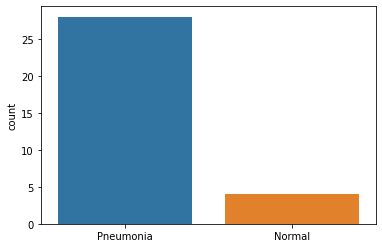

In [7]:
labels = ['Normal' if label == 0 else 'Pneumonia' for label in trainY]
sns.countplot(labels)

Here, as we can see clearly from the count plot that we have sufficient examples for pneumonia cases to train our model.

### Visualize the first 10 images from out training set

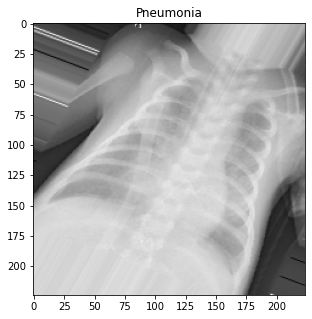

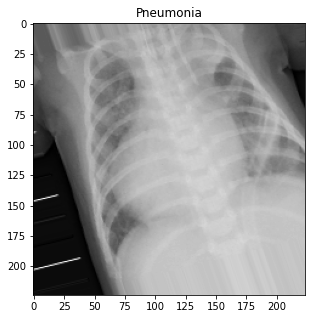

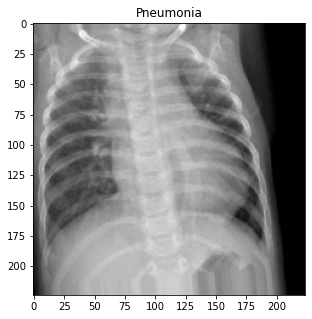

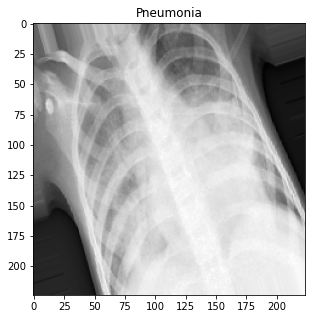

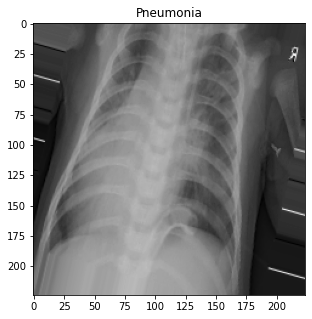

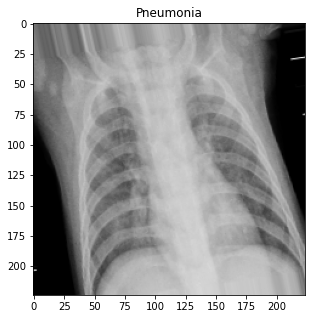

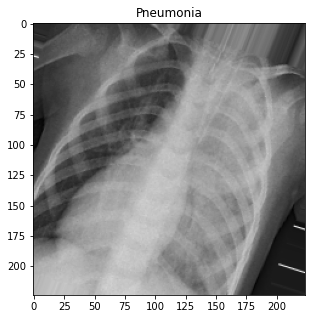

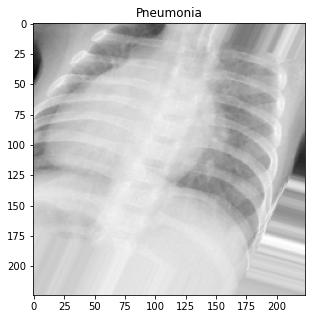

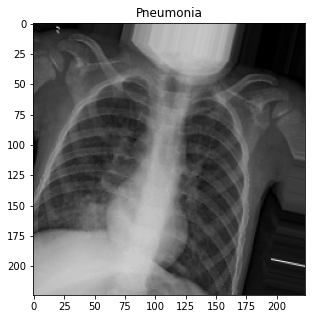

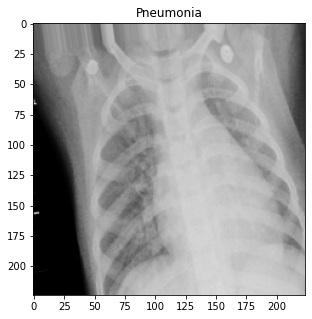

In [8]:
for idx in range(10):
    plt.figure(figsize=(5,5))
    plt.imshow(trainX[idx].reshape(224,224), cmap='gray')
    plt.title(labels[idx])

In [9]:
print('TrainX : ',trainX[0].shape)

TrainX :  (224, 224, 1)


### Define our CNN model architecture

In [10]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (224, 224,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0

Here we are using **ReduceLROnPlateau** which is used to reduce the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [12]:
history = model.fit(train ,batch_size=64, epochs = 14 , validation_data = val ,callbacks = [learning_rate_reduction])

Epoch 1/14
163/163 [==============================] - 117s 715ms/step - loss: 0.9403 - accuracy: 0.8244 - val_loss: 23.2464 - val_accuracy: 0.5000
Epoch 2/14
163/163 [==============================] - 73s 447ms/step - loss: 0.2864 - accuracy: 0.8947 - val_loss: 31.6640 - val_accuracy: 0.5000
Epoch 3/14
163/163 [==============================] - ETA: 0s - loss: 0.2315 - accuracy: 0.9197
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 72s 441ms/step - loss: 0.2315 - accuracy: 0.9197 - val_loss: 29.9243 - val_accuracy: 0.5000
Epoch 4/14
163/163 [==============================] - 74s 455ms/step - loss: 0.1490 - accuracy: 0.9444 - val_loss: 38.7299 - val_accuracy: 0.5000
Epoch 5/14
163/163 [==============================] - 75s 458ms/step - loss: 0.1312 - accuracy: 0.9536 - val_loss: 2.3104 - val_accuracy: 0.6250
Epoch 6/14
163/163 [==============================] - 75s 461ms/step - loss: 0.1243 - accuracy: 0.9599 - 

In [13]:
print("Loss of the model is - " , model.evaluate(testX,testY)[0])
print("Accuracy of the model is - " , model.evaluate(testX,testY)[1]*100 , "%")

1/1 [==============================] - 0s 9ms/step - loss: 0.2781 - accuracy: 0.9688
Loss of the model is -  0.27805572748184204
1/1 [==============================] - 0s 9ms/step - loss: 0.2781 - accuracy: 0.9688
Accuracy of the model is -  96.875 %


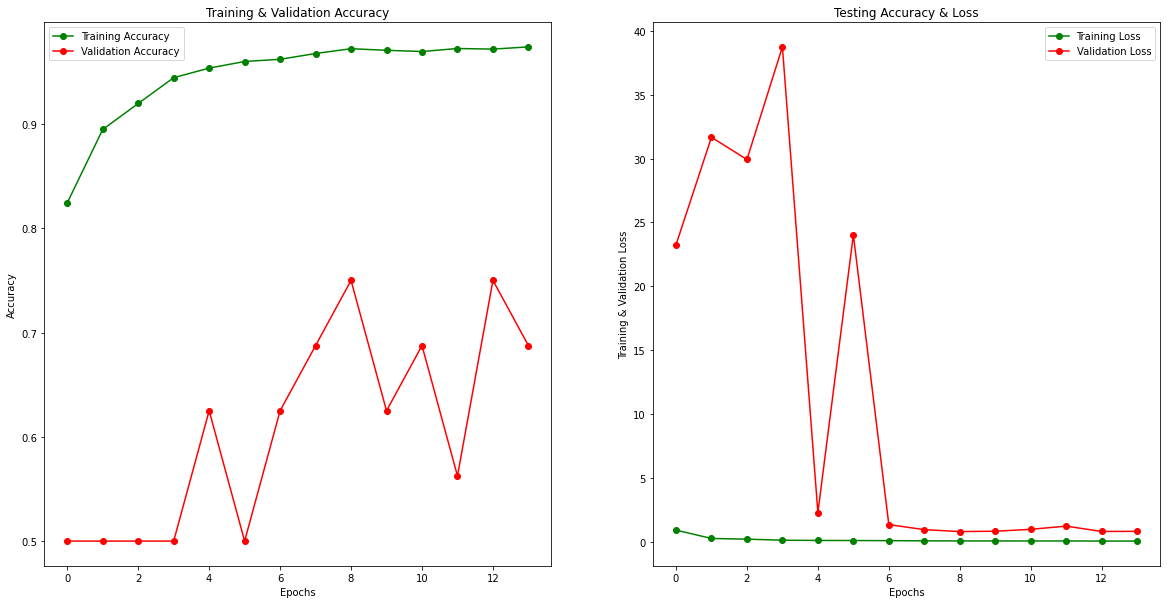

In [14]:
epochs = [i for i in range(14)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [15]:
predictions = model.predict_classes(testX)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1], dtype=int32)

In [16]:
print(classification_report(testY, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       1.00      0.90      0.95        10
   Normal (Class 1)       0.96      1.00      0.98        22

           accuracy                           0.97        32
          macro avg       0.98      0.95      0.96        32
       weighted avg       0.97      0.97      0.97        32



In [17]:
print('Confusion Matrix\n')
matrix = confusion_matrix(testY,predictions)
print(matrix)

Confusion Matrix

[[ 9  1]
 [ 0 22]]


In [18]:
correct = np.nonzero(predictions == testY)[0]
incorrect = np.nonzero(predictions != testY)[0]
print(len(correct), len(incorrect))

31 1


### Visualize correct predictions

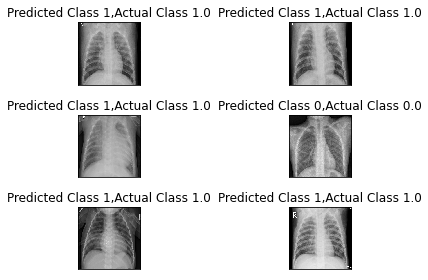

In [19]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(testX[c].reshape(224, 224), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], testY[c]))
    plt.tight_layout()
    i += 1

### Visualize incorrect predictions

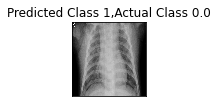

In [20]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(testX[c].reshape(224, 224), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], testY[c]))
    plt.tight_layout()
    i += 1